# Input data

In [1]:
import gurobipy as gb
import numpy as np
import pandas as pd

gen_costs = pd.read_excel('gen_costs.xlsx')
gen_data = pd.read_excel('gen_data.xlsx')
line_data = pd.read_excel('line_data.xlsx')
system_demand = pd.read_excel('system_demand.xlsx')
load_distribution = pd.read_excel('load_distribution.xlsx')

wind_data = []
for i in range(6):
    wind_data.append(pd.read_csv('wind 1.out'))


n_bus = 24

#per-unit bases - always use per unit for power flow calculations :)
S_base_3ph = 100 #MW

bus_data = pd.DataFrame(index = np.arange(n_bus), data = np.zeros(n_bus), columns = ['Load'])
bus_data['Wind'] = 0

line_data['Susceptance pu'] = 1 / line_data['Reactance pu']
line_data['Capacity pu'] = line_data['Capacity MVA'] / S_base_3ph
branch_matrix = np.zeros((n_bus, n_bus)) #susceptance

#Filling out susceptance matrix

for n in range(1, n_bus + 1):
    branch_matrix[n - 1][n - 1] = line_data.loc[(line_data['From'] == n) | (line_data['To'] == n), 'Susceptance pu'].sum()
    for k in range(n, n_bus + 1): #start from n
        if k != n:
            branch_matrix[n - 1][k - 1] = -1 * (line_data.loc[(line_data['From'] == n) & (line_data['To'] == k), 'Susceptance pu'].sum())
            branch_matrix[k - 1][n - 1] = branch_matrix[n - 1][k - 1]

# Task 1 (single time step)

In [6]:
#Choosing to run for the first hour
load = np.zeros(n_bus)
demand = system_demand['System Demand'][0]

for n in load_distribution['Node'].unique():
    load[n] = load_distribution.loc[load_distribution['Node'] == n, r'% of system load'] / 100 * demand / S_base_3ph #per-unitized

load

C:\Users\Markus\AppData\Local\Temp\ipykernel_20776\134575464.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  load[n] = load_distribution.loc[load_distribution['Node'] == n, r'% of system load'] / 100 * demand / S_base_3ph


array([0.        , 0.6748173 , 0.6037839 , 1.11877605, 0.4617171 ,
       0.44395875, 0.8524008 , 0.7813674 , 1.065501  , 1.08325935,
       1.2075678 , 0.        , 0.        , 1.65152655, 1.2075678 ,
       1.97117685, 0.62154225, 0.        , 2.07772695, 1.1365344 ,
       0.79912575, 0.        , 0.        , 0.        ])

Setting up a dictionary which maps bus indices to generator indices for easier looping - note that it accounts for zero-indexing, so the generator indices go from 0 to 11

In [4]:
gens_map = {}

for n in range(1, n_bus + 1):
    gens_map[n - 1] = (gen_data['Unit #'][gen_data['Node'] == n] - 1).tolist()

In [5]:
gens_map.get(14) #example: get the generator indices at bus 14 (15 in the assignment formulation)

[4, 5]

### Setup model and solve

Be aware that power values (also loads) need to be in per-unit

To do: Include wind power - add option for curtailment? Will probably never happen because the wind power is free

P_min of the generators can be set to 0! Only use day-ahead costs and disregard ramping.

In [82]:
direction = gb.GRB.MINIMIZE #Min / Max

# Create a Gurobi model       
m = gb.Model()

# Add variables
p_G = m.addVars(len(gen_data.index), lb=0, ub=gb.GRB.INFINITY, name="P_G") #Note: This is in per unit
theta = m.addVars(n_bus, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="theta")

# Set objective function
obj = gb.quicksum(gen_costs['C ($/MWh)'][k] * p_G[k] * S_base_3ph for k in range(len(p_G))) #converted back to MW since the prices are per MWh and the power is per-unitized         
m.setObjective(obj, direction)


#Setting up balance equation for each node n using the gens_map dictionary
for n in range(n_bus):
    m.addConstr(gb.quicksum(p_G[g] for g in gens_map.get(n)) - load[n] == theta[n] * branch_matrix[n,n] + gb.quicksum(theta[k] * branch_matrix[n,k] for k in range(n_bus) if k != n))

#Managing line capacities - remembering that the "to" and "from" are not zero-indexed in the data
for n in range(n_bus):
    for k in range(n, n_bus): #Avoid duplicates by starting the indexing of k at i
        if (n != k) and (branch_matrix[n,k] != 0):
            m.addConstr((theta[n] - theta[k]) * branch_matrix[n,k] <= (line_data.loc[(line_data['From'] == n + 1) & (line_data['To'] == k + 1), 'Capacity pu'].sum()))
            m.addConstr((theta[n] - theta[k]) * branch_matrix[n,k] >= -1 * (line_data.loc[(line_data['From'] == n + 1) & (line_data['To'] == k + 1), 'Capacity pu'].sum()))

m.addConstrs(p_G[g] <= (gen_data['P max MW'].iloc[g] / S_base_3ph) for g in range(len(gen_data))) #if the generator is on (s_G[i] = 1), then the limit is p_max
m.addConstrs(p_G[g] >= 0 for g in range(len(gen_data))) #P_min from the system should be disregarded to avoid having a mixed integer program
m.addConstr(theta[0] == 0)

m.update()
m.display()

m.optimize()

#Fix the values of the binary variables from the optimal solution and run again as a continuous LP to get dual values of the solution
# fixed = m.fixed()
# fixed.optimize()

Minimize
1332.0 P_G[0] + 1332.0 P_G[1] + 2070.0 P_G[2] + 2093.0 P_G[3] + 2611.0 P_G[4]
+ 1052.0 P_G[5] + 1052.0 P_G[6] + 602.0 P_G[7] + 547.0 P_G[8] + 1052.0 P_G[10]
+ 1089.0 P_G[11]
Subject To
R0: P_G[0] + -83.95703541830918 theta[0] + 68.4931506849315 theta[1] +
 4.438526409232135 theta[2] + 11.025358324145534 theta[4] = 0
R1: P_G[1] + 68.4931506849315 theta[0] + -80.74583073385588 theta[1] +
 7.374631268436579 theta[3] + 4.878048780487805 theta[5] = 0.674817
R2: 4.438526409232135 theta[0] + -24.211108927684045 theta[2] + 7.867820613690008
 theta[8] + 11.904761904761903 theta[23] = 0.603784
R3: 7.374631268436579 theta[1] + -16.383640277445586 theta[3] + 9.00900900900901
 theta[8] = 1.11878
R4: 11.025358324145534 theta[0] + -21.66365619648596 theta[4] + 10.638297872340425
 theta[9] = 0.461717
R5: 4.878048780487805 theta[1] + -20.454372768026747 theta[5] + 15.576323987538942
 theta[9] = 0.443959
  R6: P_G[2] + -15.337423312883438 theta[6] + 15.337423312883438 theta[7] = 0.852401
R7: 15

### Analyze results

In [89]:
#Print solutions
if m.status == gb.GRB.OPTIMAL:
    results = {} #to be included: branch flows, theta, generator outputs
    branch_flows = pd.DataFrame(columns=['From', 'To', 'Flow', 'Loading Percentage'])
    theta_res = pd.DataFrame(data=np.zeros(n_bus), columns=['theta'])
    theta_res['theta_deg'] = 0
    generator_outputs = pd.DataFrame(data=np.zeros(len(p_G)), columns=['p_G'])
    generator_outputs['Node'] = gen_data['Node'].values - 1 #0-indexed

    constraints = m.getConstrs()
    # The constraint dual value / sensitivity in the current solution (also known as the shadow price)... https://www.gurobi.com/documentation/9.5/refman/pi.html
    optimized_sens = [constraints[k].Pi for k in range(len(constraints))] 
    print('-----------------------------------------------')
    print("Optimal objective value: %.2f DKK" % m.objVal)

    for i in range(n_bus):
        print(theta[i].VarName + ": %.2f rad" % theta[i].x)
        theta_res.loc[theta_res.index == i, 'theta'] = theta[i].x
        theta_res.loc[theta_res.index == i, 'theta_deg'] = theta[i].x * 180 / np.pi

    for i in range(len(p_G)):
        print(p_G[i].VarName + ": %.2f pu" % p_G[i].x)
        generator_outputs.loc[generator_outputs.index == i, 'p_G'] = p_G[i].x

    for k in range(len(constraints)):
        print('Dual value {0}: '.format(k+1), optimized_sens[k])

    print("\nFlows:")
    for i in range(n_bus):
        for k in range(i, n_bus):
            if (i != k) and (branch_matrix[i,k] != 0):
                flow = (theta[i].x - theta[k].x) * branch_matrix[i,k] #compute branch flow from results and branch matrix
                flow_limit = line_data.loc[(line_data['From'] == i + 1) & (line_data['To'] == k + 1), 'Capacity pu'].sum() #get flow limit for the branch
                loading_percentage = (abs(flow) / flow_limit) * 100

                new_row = {'From': [i], 'To': [k], 'Flow': [flow], 'Loading Percentage':loading_percentage}
                branch_flows = pd.concat([branch_flows, pd.DataFrame(new_row)], axis=0)
                print('From %d to %d: %.2f pu     (%.2f %%)' % (i + 1, k + 1, flow , loading_percentage))
    
    for i in range(n_bus):
        net_flow = 0
        for k in range(n_bus):
            if (i != k) and (branch_matrix[i,k] != 0):
                net_flow += (theta[i].x - theta[k].x) * branch_matrix[i,k]
        print('Bus %d net injection: %.2f pu' % (i + 1, net_flow))

    print("\nTotal load: %.2f MWh" % (sum(load[n] for n in range(n_bus)) * S_base_3ph))
    print("Total generation: %.2f MWh" % (sum(p_G[n].x for n in range(len(p_G))) * S_base_3ph))

    results['gen'] = generator_outputs.copy(deep=True)
    results['flows'] = branch_flows.copy(deep=True)
    results['theta'] = theta_res.copy(deep=True)

else:
    print("Optimization was not successful.")     
  
        
# Dispose of the Gurobi model to release resources
#m.dispose()

-----------------------------------------------
Optimal objective value: 11726.44 DKK
theta[0]: 0.00 rad
theta[1]: -0.01 rad
theta[2]: 0.19 rad
theta[3]: -0.04 rad
theta[4]: -0.00 rad
theta[5]: 0.00 rad
theta[6]: -0.15 rad
theta[7]: -0.09 rad
theta[8]: 0.07 rad
theta[9]: 0.04 rad
theta[10]: 0.14 rad
theta[11]: 0.16 rad
theta[12]: 0.20 rad
theta[13]: 0.23 rad
theta[14]: 0.51 rad
theta[15]: 0.46 rad
theta[16]: 0.58 rad
theta[17]: 0.64 rad
theta[18]: 0.38 rad
theta[19]: 0.36 rad
theta[20]: 0.63 rad
theta[21]: 0.74 rad
theta[22]: 0.36 rad
theta[23]: 0.38 rad
P_G[0]: 0.00 pu
P_G[1]: 0.00 pu
P_G[2]: 0.00 pu
P_G[3]: 0.00 pu
P_G[4]: 0.00 pu
P_G[5]: 1.55 pu
P_G[6]: 1.55 pu
P_G[7]: 4.00 pu
P_G[8]: 4.00 pu
P_G[9]: 3.00 pu
P_G[10]: 3.10 pu
P_G[11]: 0.56 pu
Dual value 1:  1089.0000000000039
Dual value 2:  1089.0000000000036
Dual value 3:  1089.000000000001
Dual value 4:  1089.0000000000018
Dual value 5:  1089.0000000000023
Dual value 6:  1089.0000000000011
Dual value 7:  1089.0000000000002
Dual val

To do: Visualize results - bar plots like in my bachelor's thesis :)

Plots that would be nice to have: Generator outputs, branch flows, wind farm outputs, theta (2x2 grid of subplots)

In [86]:
import matplotlib.pyplot as plt

plt.rcParams['font.size']=12
plt.rcParams['font.family']='serif'
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.bottom'] = True     
plt.rcParams["axes.grid"] =True
plt.rcParams['grid.linestyle'] = '-.' 
plt.rcParams['grid.linewidth'] = 0.4

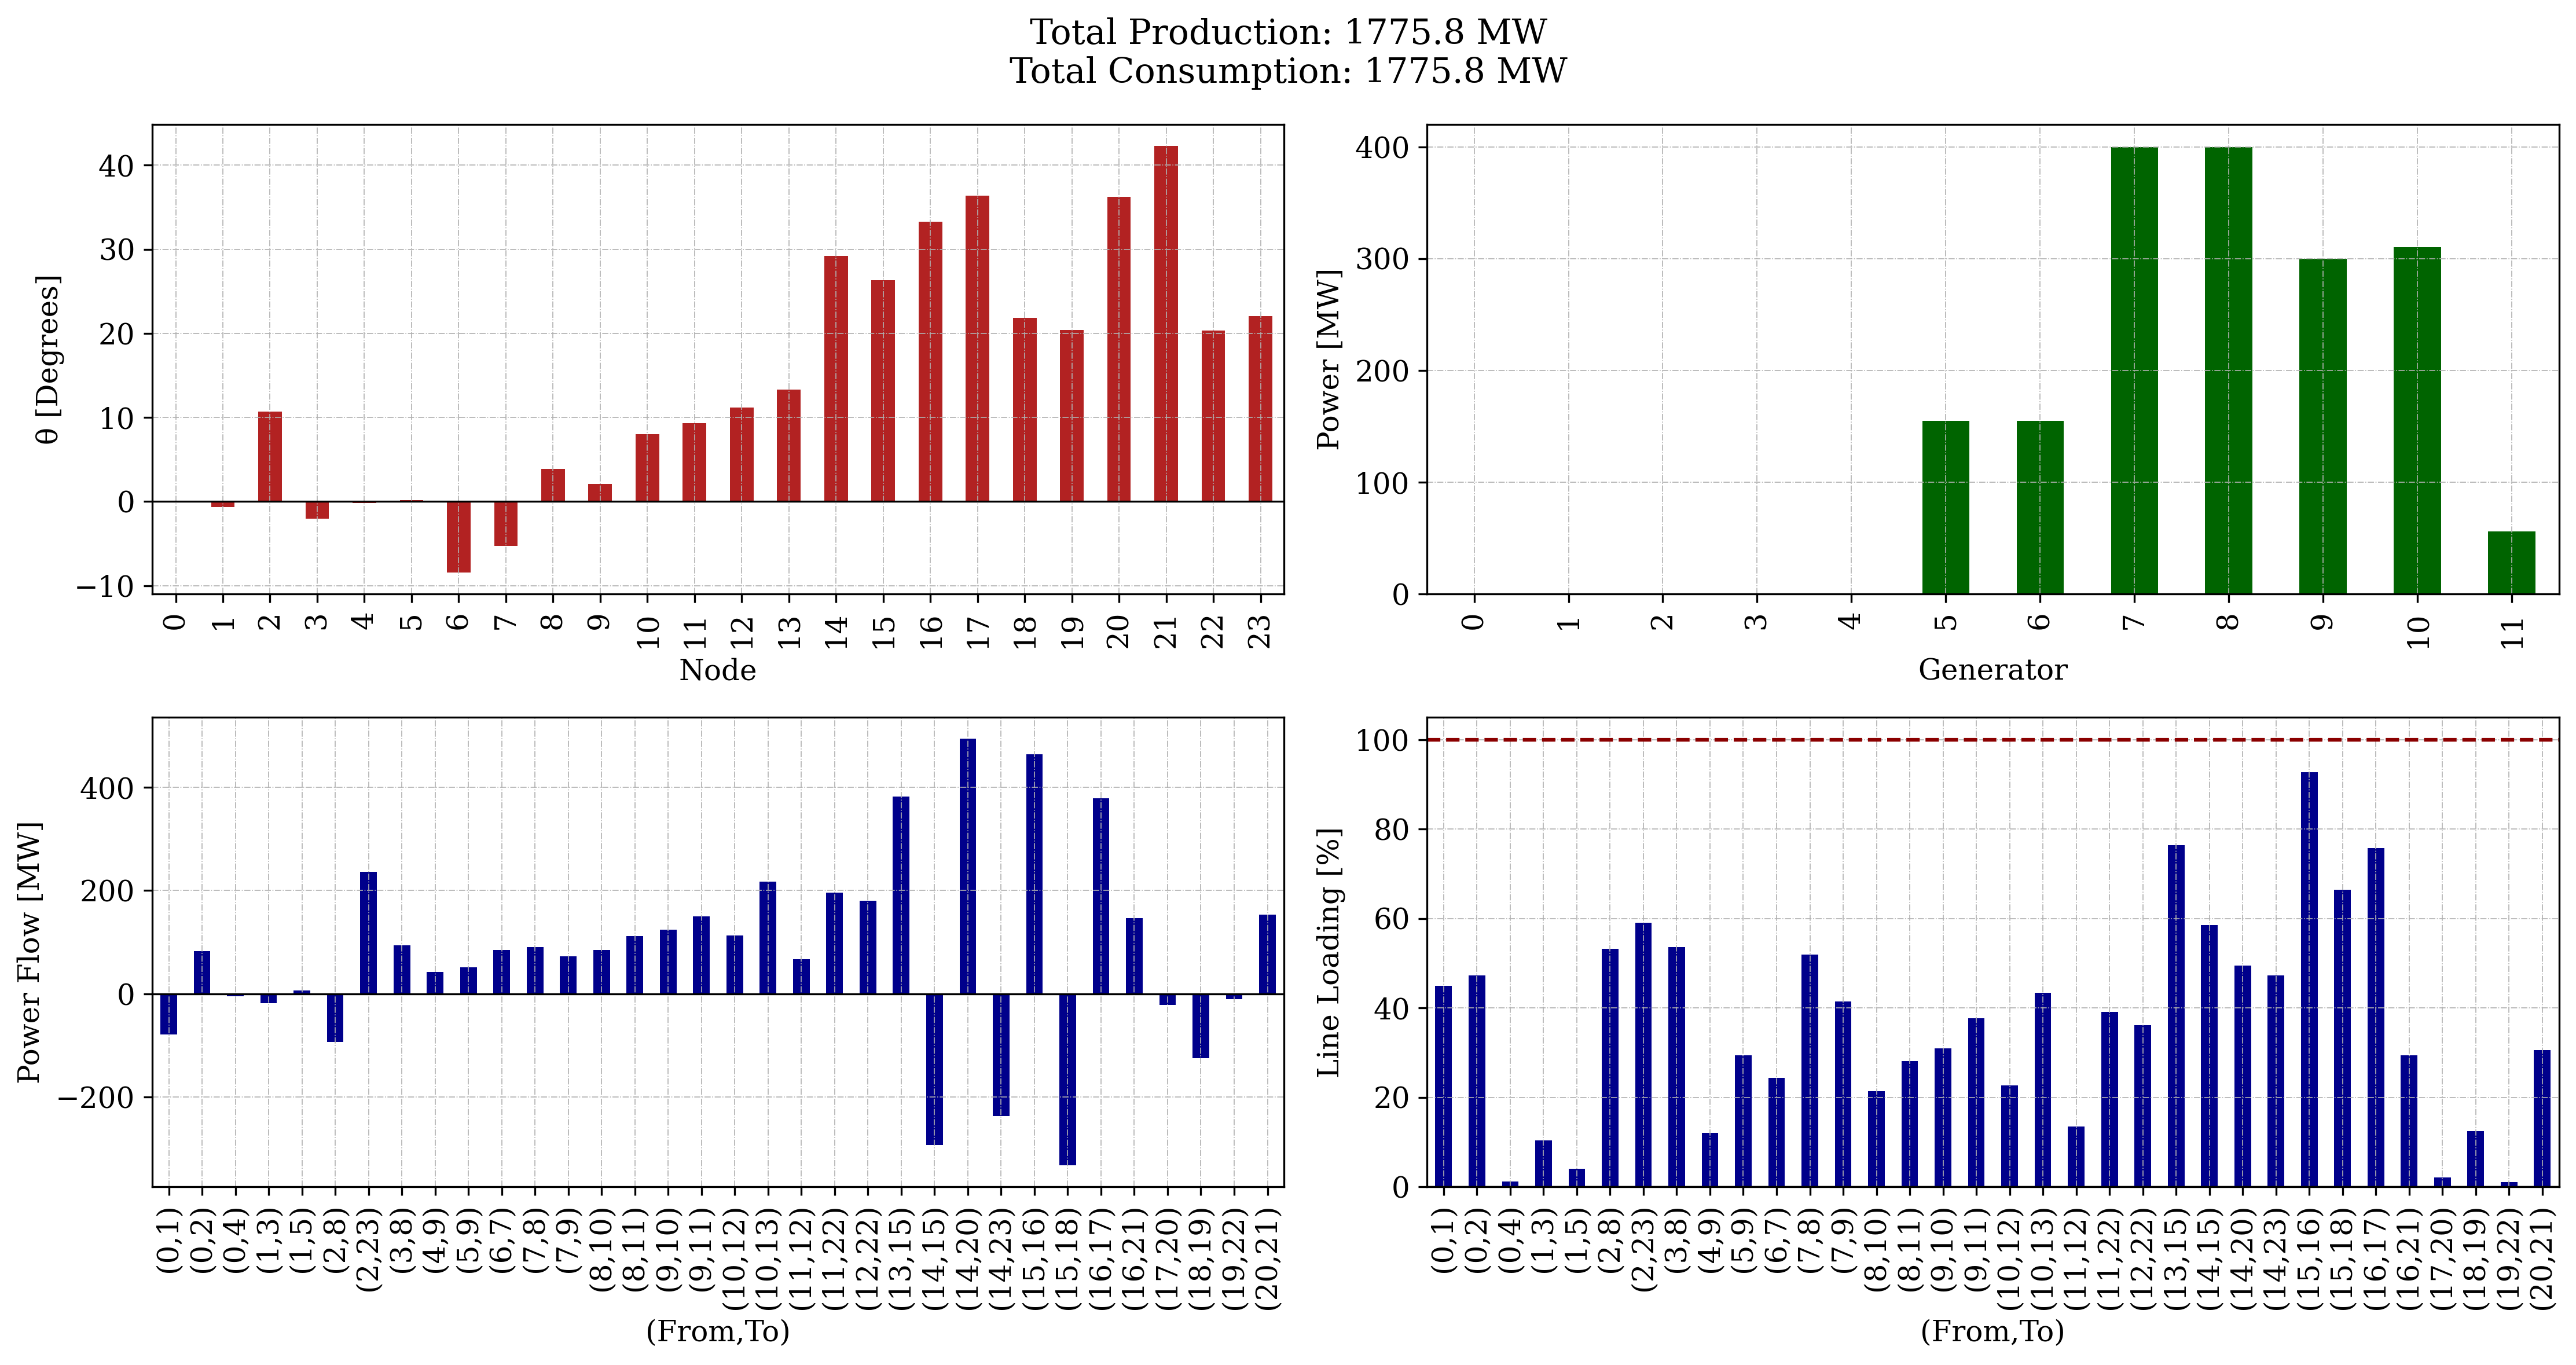

In [107]:
fig, ax = plt.subplots(2,2,figsize=( 15 , 8 ) , dpi=300) # Create the figure

results.get('theta')['theta_deg'].plot(kind='bar', ax=ax[0][0], color='firebrick')
ax[0][0].set_ylabel('\u03B8 [Degrees]')
ax[0][0].set_xlabel('Node')

(results.get('gen')['p_G'] * S_base_3ph).plot(kind='bar', ax=ax[0][1], color='darkgreen')
ax[0][1].set_ylabel('Power [MW]')
ax[0][1].set_xlabel('Generator')

(results.get('flows')['Flow'] * S_base_3ph).plot(kind='bar', ax=ax[1][0], color='darkblue')
ax[1][0].set_ylabel('Power Flow [MW]')
ax[1][0].set_xlabel('(From,To)')

results.get('flows')['Loading Percentage'].plot(kind='bar', ax=ax[1][1], color='darkblue')
ax[1][1].axhline(100, color='darkred', linestyle='--')
ax[1][1].set_ylabel('Line Loading [%]')
ax[1][1].set_xlabel('(From,To)')

for i in range(2):
    for k in range(2):
        ax[i][k].axhline(0, color='black', linewidth=0.8)

flow_labels = []

for row in range(len(branch_flows)):
    label = '(' + str(branch_flows.iloc[row, 0]) + ',' + str(branch_flows.iloc[row, 1]) + ')'
    flow_labels.append(label)

ax[1][0].set_xticks(ticks = np.arange(0, len(flow_labels), 1), labels = flow_labels)
ax[1][1].set_xticks(ticks = np.arange(0, len(flow_labels), 1), labels = flow_labels)

plt.suptitle('Total Production: %.1f MW\nTotal Consumption: %.1f MW' % (results.get('gen')['p_G'].sum() * S_base_3ph,
                                                                        (sum(load[n] for n in range(n_bus)) * S_base_3ph)))

fig.tight_layout() # reduces white space around figures
#plt.savefig('results.png',bbox_inches='tight')
plt.show()